In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from sklearn.model_selection import train_test_split
K.set_image_dim_ordering('th')
%matplotlib 

Using matplotlib backend: nbAgg


In [1]:
img_height, img_width = 480,640
from keras.preprocessing import image
from itertools import izip

batch_size = 2
def hot_vectorize(x):
    zero_mask = x==0
    non_zero_mask = x!=0
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x

def combine_data_generators(depth,normal,rgb,mask):
    while True:
            d = depth.next()
            n = normal.next()
            r = rgb.next()
            m = mask.next()
            yield (np.concatenate((d,n,r),3),m)
            
labeldatagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        #zoom_range=.5,plt.figure()
        preprocessing_function = hot_vectorize,
        data_format="channels_last")

datagen = image.ImageDataGenerator(
        #preprocessing_function=applications.xception.preprocess_input,
        #preprocessing_function = random_crop,
        rescale =1/255.,
        #zoom_range=.5,
        data_format="channels_last")

flow_from_directory_params_grey = {'target_size': (img_height,img_width),
                                  'color_mode': 'grayscale',
                                  'class_mode': None,
                                  'batch_size': batch_size}

flow_from_directory_params_color = {'target_size': (img_height,img_width),
                                  'color_mode': 'rgb',
                                  'class_mode': None,
                                  'batch_size': batch_size}


mask_generator = labeldatagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/depth",
        shuffle = False,
        **flow_from_directory_params_grey
    )
rgb_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/rgb",
        shuffle = False,
        **flow_from_directory_params_color
    )
normal_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/normal",
        shuffle = False,
        **flow_from_directory_params_color
    )
gt_generator = datagen.flow_from_directory(
        directory="/media/drc/DATA/CNN/gtdepth",
        shuffle =False,
        **flow_from_directory_params_grey
    )

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 117661 images belonging to 1 classes.
Found 117661 images belonging to 1 classes.
Found 117521 images belonging to 1 classes.
Found 117521 images belonging to 1 classes.


In [2]:
train_generator = combine_data_generators(gt_generator,normal_generator,rgb_generator,mask_generator)

In [5]:
inputs = Input((img_height, img_width,7))

In [6]:
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(7, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(7, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv4 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(drop4)

conv5 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool4)
conv5 = Conv2D(136, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(112, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(drop5))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge6)
conv6 = Conv2D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv6)

up7 = Conv2D(56, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(28, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(28, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(14, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
print model.summary()
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 7)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 7)  448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 7)  448         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 7)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: UserWarning: The `m

In [7]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model.fit_generator(train_generator, nb_epoch=100,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=100, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 0.4217 - acc: 0.8205
Epoch 00001: loss improved from inf to 0.42073, saving model to unet.hdf5
100/100 [==============================] - 26s 258ms/step - loss: 0.4207 - acc: 0.8207
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.8599
Epoch 00002: loss improved from 0.42073 to 0.33372, saving model to unet.hdf5
100/100 [==============================] - 22s 217ms/step - loss: 0.3337 - acc: 0.8607
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3079 - acc: 0.9211
Epoch 00003: loss improved from 0.33372 to 0.30753, saving model to unet.hdf5
100/100 [==============================] - 25s 254ms/step - loss: 0.3075 - acc: 0.9213
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2795 - acc: 0.9259
Epoch 00004: loss improved from 0.30753 to 0.27906, saving model to unet.hdf5
100/100 [==============================] - 25s 251ms/step - los

Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1796 - acc: 0.9543
Epoch 00034: loss did not improve
100/100 [==============================] - 27s 274ms/step - loss: 0.1793 - acc: 0.9544
Epoch 35/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1805 - acc: 0.9538
Epoch 00035: loss did not improve
100/100 [==============================] - 27s 273ms/step - loss: 0.1804 - acc: 0.9538
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1777 - acc: 0.9545
Epoch 00036: loss improved from 0.17758 to 0.17743, saving model to unet.hdf5
100/100 [==============================] - 27s 273ms/step - loss: 0.1774 - acc: 0.9546
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1763 - acc: 0.9545
Epoch 00037: loss improved from 0.17743 to 0.17607, saving model to unet.hdf5
100/100 [==============================] - 28s 278ms/step - loss: 0.1761 - acc: 0.9546
Epoch 38/100
 99/100 [============================>.] - 

 99/100 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.9582
Epoch 00069: loss improved from 0.15366 to 0.15300, saving model to unet.hdf5
100/100 [==============================] - 29s 289ms/step - loss: 0.1530 - acc: 0.9582
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1545 - acc: 0.9579
Epoch 00070: loss did not improve
100/100 [==============================] - 28s 276ms/step - loss: 0.1543 - acc: 0.9580
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9580
Epoch 00071: loss did not improve
100/100 [==============================] - 28s 282ms/step - loss: 0.1534 - acc: 0.9581
Epoch 72/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1558 - acc: 0.9559
Epoch 00072: loss did not improve
100/100 [==============================] - 28s 284ms/step - loss: 0.1556 - acc: 0.9560
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1511 - acc: 0.9585
Epoch 00073: loss im

In [14]:
np.shape(X_Test)

(2, 480, 640, 7)

In [8]:
test = train_generator.next()
X_Test = test[0][0:10]
Y_Test = test[1][0:10]
imgs_mask_test = model.predict_on_batch(X_Test)

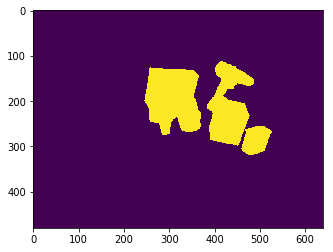

In [29]:
%matplotlib inline
img = np.reshape(X_Test[0,:,:,0],(img_height,img_width))
plt.imshow(img)

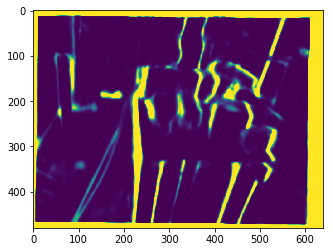

In [16]:
%matplotlib inline
index = np.random.randint(3)
img = np.reshape(imgs_mask_test[0],(img_height,img_width))
plt.imshow(img)

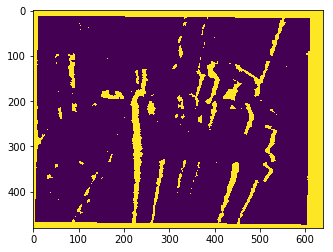

In [15]:
%matplotlib inline
img = np.reshape(Y_Test[0],(img_height,img_width))
plt.imshow(img)

In [169]:
train = train_generator.next()
X = train[0]
Y = train[1]
inputs = Input((1,img_height, img_width))

In [171]:
conv1 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(inputs)

conv2 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv1)

conv3 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv2)

conv4 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv3)
#drop4 = Dropout(0.5)(conv4)

conv5 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv4)

conv6 = Conv2D(1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_first')(conv5)
#drop5 = Dropout(0.5)(conv5)

model1 = Model(input = inputs, output = conv6)
print model1.summary()
model1.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 480, 640)       0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 32, 480, 640)      832       
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 64, 480, 640)      51264     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 32, 480, 640)      51232     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 16, 480, 640)      4624      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 4, 480, 640)       580       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 1, 480, 640)       37        
Total para

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [217]:
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
print('Fitting model...')
model1.fit_generator(train_generator, steps_per_epoch=100,nb_epoch=10, verbose=1, shuffle=True, callbacks=[model_checkpoint])

Fitting model...
Epoch 1/10
  1/100 [..............................] - ETA: 13s - loss: 0.3969 - acc: 0.8304

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<itertools..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10, callbacks=[<keras.ca...)`
  This is separate from the ipykernel package so we can avoid doing imports until


 99/100 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8321
Epoch 00001: loss improved from inf to 0.38894, saving model to unet.hdf5
100/100 [==============================] - 10s 100ms/step - loss: 0.3889 - acc: 0.8322
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3845 - acc: 0.8345
Epoch 00002: loss improved from 0.38894 to 0.38439, saving model to unet.hdf5
100/100 [==============================] - 10s 97ms/step - loss: 0.3844 - acc: 0.8345
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3850 - acc: 0.8282
Epoch 00003: loss did not improve
100/100 [==============================] - 10s 97ms/step - loss: 0.3851 - acc: 0.8281
Epoch 4/10
 99/100 [============================>.] - ETA: 0s - loss: 0.3777 - acc: 0.8301
Epoch 00004: loss improved from 0.38439 to 0.37768, saving model to unet.hdf5
100/100 [==============================] - 10s 98ms/step - loss: 0.3777 - acc: 0.8301
Epoch 5/10
 99/100 [==================

In [229]:
test = train_generator.next()
X_Test = test[0][0:50]
Y_Test = test[1][0:50]

In [232]:
np.shape(X_Test),np.shape(imgs_mask_test)

((1, 1, 480, 640), (1, 1, 480, 640))

In [236]:
imgs_mask_test = model1.predict_on_batch(X_Test)

In [284]:
%matplotlib inline

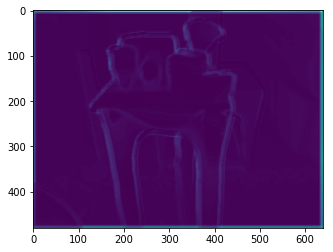

In [242]:
index = np.random.randint(10)
img = np.reshape(imgs_mask_test,(img_height,img_width))
plt.imshow(img)